<a href="https://colab.research.google.com/github/Aravindh4404/FYPSeagullClassification01/blob/main/OrigAdultInflightResnet1310.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Set the data root directories
train_data_root = "/content/drive/My Drive/FYP/Dataset/Original_Adult_In-flight/train"
test_data_root = "/content/drive/My Drive/FYP/Dataset/Original_Adult_In-flight/test"


# Image size for resizing
IMAGE_SHAPE = (224, 224)

# Create ImageDataGenerators with augmentation for training and simple scaling for test
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],  # Adjust brightness
    contrast_stretching=True  # Contrast adjustments
)


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# Define training and validation generators from the training dataset
train_generator = train_datagen.flow_from_directory(
    train_data_root,      # Use the same training directory
    subset="training",     # 80% for training
    shuffle=True,
    target_size=IMAGE_SHAPE,
    class_mode='categorical',
    batch_size=16
)

valid_generator = train_datagen.flow_from_directory(
    train_data_root,      # Use the same training directory
    subset="validation",   # 20% for validation
    shuffle=False,
    target_size=IMAGE_SHAPE,
    class_mode='categorical',
    batch_size=16
)

# Define the test generator for final evaluation
test_generator = test_datagen.flow_from_directory(
    test_data_root,
    target_size=IMAGE_SHAPE,
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

# Print class indices to understand label mapping
print("Class Indices:", train_generator.class_indices)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


TypeError: ImageDataGenerator.__init__() got an unexpected keyword argument 'contrast_stretching'

In [ ]:
# Define input shape
input_shape = (224, 224, 3)

# Load ResNet50 model with pre-trained ImageNet weights, exclude the top layer
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

# Freeze base model layers to prevent retraining
base_model.trainable = False

# Define the model
inputs = tf.keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary for review
model.summary()


In [48]:
# Check the number of validation samples
print(f"Number of validation samples: {valid_generator.samples}")

# Fetch a batch from validation to check if it's working
batch = valid_generator.__getitem__(0)  # Fetch the first batch from validation
print(f"Validation batch shape: {batch[0].shape}, Labels shape: {batch[1].shape}")

# Ensure that steps_per_epoch and validation_steps are set correctly
steps_per_epoch = max(1, np.ceil(train_generator.samples / train_generator.batch_size).astype(int))
validation_steps = 3

# Print to verify steps
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

# Train the model with training and validation data
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=40,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)


Number of validation samples: 75
Validation batch shape: (16, 224, 224, 3), Labels shape: (16, 2)
Steps per epoch: 11
Validation steps: 3
Epoch 1/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 261ms/step - accuracy: 0.5177 - loss: 0.7539 - val_accuracy: 0.2500 - val_loss: 0.7386
Epoch 2/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.6051
Epoch 3/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step - accuracy: 0.4819 - loss: 0.7459 - val_accuracy: 0.2500 - val_loss: 0.7182
Epoch 4/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9630 - val_loss: 0.6541
Epoch 5/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 0.5728 - loss: 0.7129 - val_accuracy: 0.6458 - val_loss: 0.6858
Epoch 6/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4444 - val_loss: 0.6961
Epoch 7/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.4895 -

4/4 - 2s - 436ms/step - accuracy: 0.5882 - loss: 0.6810
Test Loss: 0.6810373663902283
Test Accuracy: 0.5882353186607361


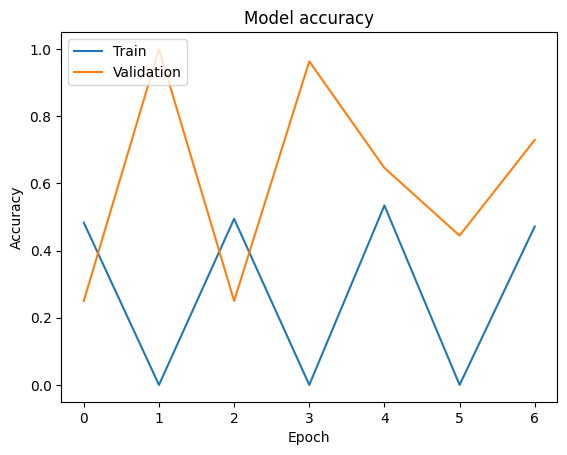

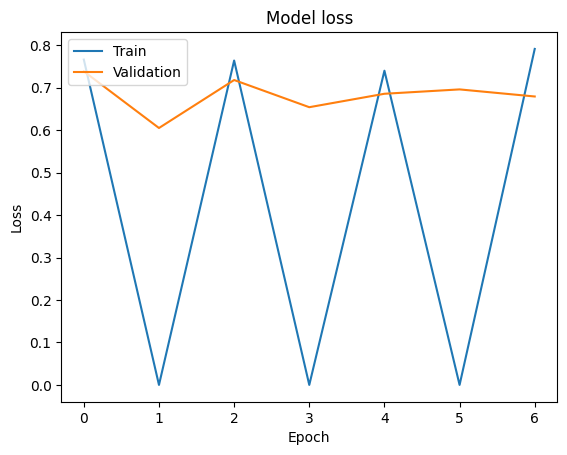

In [49]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


4/4 - 2s - 515ms/step - accuracy: 0.4510 - loss: 0.7241
Test Loss: 0.7241305708885193
Test Accuracy: 0.45098039507865906


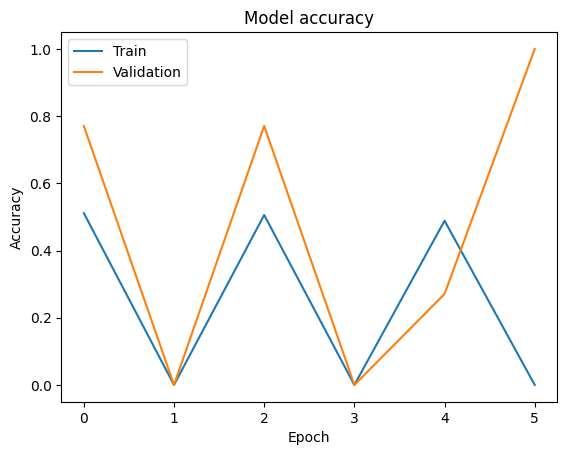

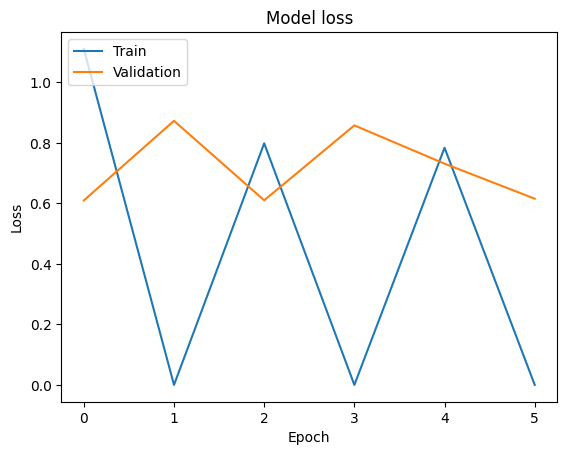

In [46]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
